In [65]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
import pandas as pd
from collections import defaultdict



In [66]:
# -------- Paths --------
DATASET_DIR = 'ewaste-dataset'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'val')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
TARGET_COUNT = 500  # Target images per class (for augmentation)

In [67]:
# -------- Helpers --------
def list_classes(base_path):
    return sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

def count_images_in_classes(base_path):
    counts = {}
    for cls in list_classes(base_path):
        cls_path = os.path.join(base_path, cls)
        counts[cls] = len([f for f in os.listdir(cls_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
    return counts

def remove_corrupted_and_non_images(base_path):
    print(f"Checking for corrupted/non-image files in {base_path}")
    for cls in list_classes(base_path):
        cls_path = os.path.join(base_path, cls)
        for fname in os.listdir(cls_path):
            fpath = os.path.join(cls_path, fname)
            if not fname.lower().endswith(('jpg', 'jpeg', 'png')):
                print(f"Deleting non-image: {fpath}")
                os.remove(fpath)
                continue
            try:
                img = Image.open(fpath)
                img.verify()
            except:
                print(f"Corrupted image removed: {fpath}")
                os.remove(fpath)

def show_class_distribution_barplot(train_stats, val_stats, test_stats):
    df = pd.DataFrame([
        [cls, 'train', count] for cls, count in train_stats.items()
    ] + [
        [cls, 'val', count] for cls, count in val_stats.items()
    ] + [
        [cls, 'test', count] for cls, count in test_stats.items()
    ], columns=['class', 'split', 'count'])

    plt.figure(figsize=(14,6))
    sns.barplot(x='class', y='count', hue='split', data=df)
    plt.title('Class Distribution Across Train/Val/Test')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def show_sample_images(base_path, class_name, n=5):
    class_path = os.path.join(base_path, class_name)
    files = random.sample(os.listdir(class_path), min(n, len(os.listdir(class_path))))
    plt.figure(figsize=(15,3))
    for i, fname in enumerate(files):
        img = Image.open(os.path.join(class_path, fname))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.suptitle(f"Sample images from {class_name} class")
    plt.show()



In [68]:
def detect_imbalanced_classes(stats, threshold=0.5):
    avg = sum(stats.values()) / len(stats)
    underrepresented = {k: v for k, v in stats.items() if v < avg * threshold}
    print(f"Underrepresented classes (less than {threshold*100:.0f}% of average):")
    print(underrepresented)
detect_imbalanced_classes(train_stats)

Underrepresented classes (less than 50% of average):
{}


In [69]:
# -------- Augmentation --------
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

def augment_class_images(class_path, target_count):
    images = os.listdir(class_path)
    current_count = len(images)
    print(f"Augmenting {class_path}: {current_count} → {target_count}")
    
    while len(os.listdir(class_path)) < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            aug_img = augmentations(img)
            new_name = f"aug_{random.randint(10000,99999)}_{img_name}"
            aug_img.save(os.path.join(class_path, new_name))
        except Exception as e:
            print(f"Error augmenting {img_name}: {e}")



In [70]:
# -------- Run Wrangling --------

# Step 1: Clean corrupted/non-image files
remove_corrupted_and_non_images(TRAIN_DIR)
remove_corrupted_and_non_images(VAL_DIR)
remove_corrupted_and_non_images(TEST_DIR)


Checking for corrupted/non-image files in ewaste-dataset\train
Checking for corrupted/non-image files in ewaste-dataset\val
Checking for corrupted/non-image files in ewaste-dataset\test


In [71]:
# Step 2: Collect stats
train_stats = count_images_in_classes(TRAIN_DIR)
val_stats = count_images_in_classes(VAL_DIR)
test_stats = count_images_in_classes(TEST_DIR)




Train stats: {'Battery': 499, 'Keyboard': 388, 'Microwave': 399, 'Mobile': 482, 'Mouse': 470, 'PCB': 500, 'Player': 500, 'Printer': 499, 'Television': 397, 'Washing Machine': 303}
Val stats: {'Battery': 30, 'Keyboard': 30, 'Microwave': 30, 'Mobile': 30, 'Mouse': 30, 'PCB': 30, 'Player': 30, 'Printer': 30, 'Television': 30, 'Washing Machine': 30}
Test stats: {'Battery': 30, 'Keyboard': 30, 'Microwave': 30, 'Mobile': 30, 'Mouse': 30, 'PCB': 30, 'Player': 30, 'Printer': 30, 'Television': 30, 'Washing Machine': 30}


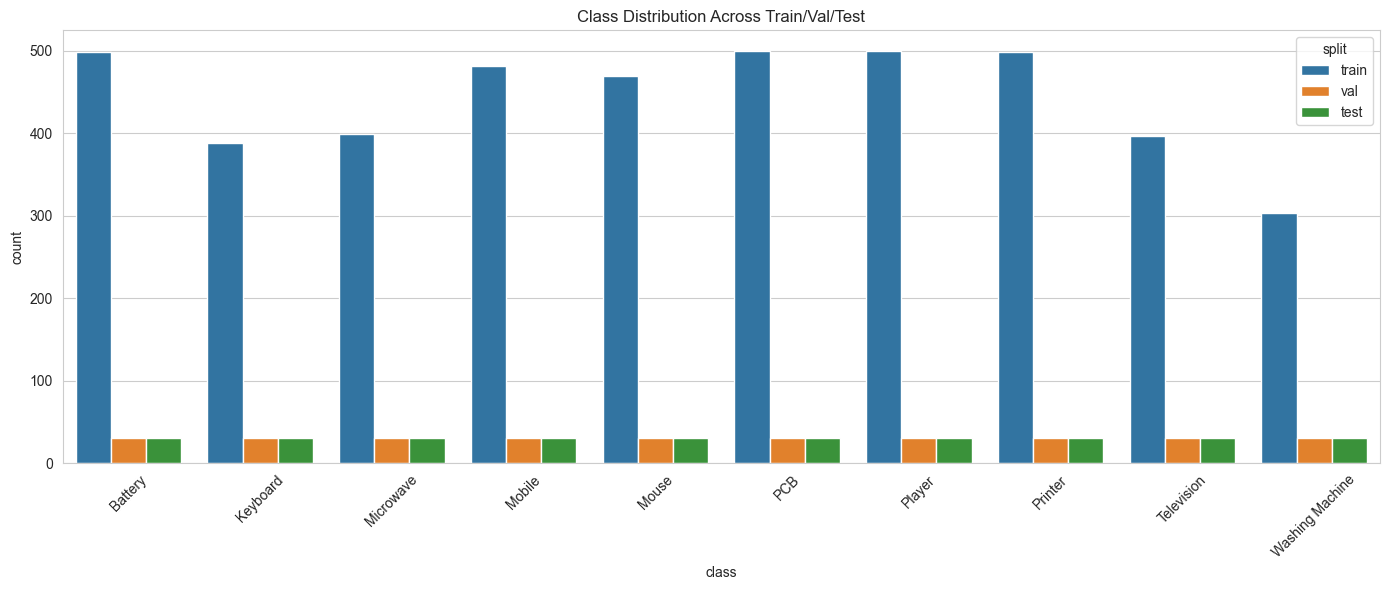

In [72]:
# Step 3: Show class distribution
print("Train stats:", train_stats)
print("Val stats:", val_stats)
print("Test stats:", test_stats)
show_class_distribution_barplot(train_stats, val_stats, test_stats)



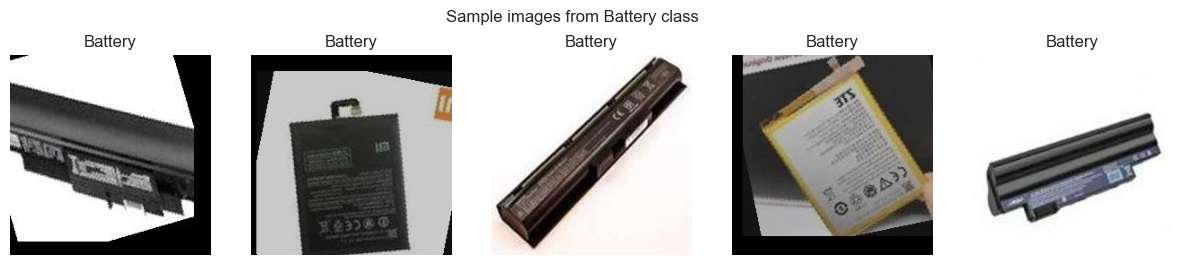

In [73]:
# Step 4: Show a few samples
example_class = list(train_stats.keys())[0]
show_sample_images(TRAIN_DIR, example_class)



Augmenting ewaste-dataset\train\Battery: 499 → 500
Augmenting ewaste-dataset\train\Keyboard: 388 → 500
Augmenting ewaste-dataset\train\Microwave: 399 → 500
Augmenting ewaste-dataset\train\Mobile: 482 → 500
Augmenting ewaste-dataset\train\Mouse: 470 → 500
Augmenting ewaste-dataset\train\Printer: 499 → 500
Augmenting ewaste-dataset\train\Television: 397 → 500
Augmenting ewaste-dataset\train\Washing Machine: 303 → 500
Updated Train stats (after augmentation): {'Battery': 500, 'Keyboard': 500, 'Microwave': 500, 'Mobile': 500, 'Mouse': 500, 'PCB': 500, 'Player': 500, 'Printer': 500, 'Television': 500, 'Washing Machine': 500}


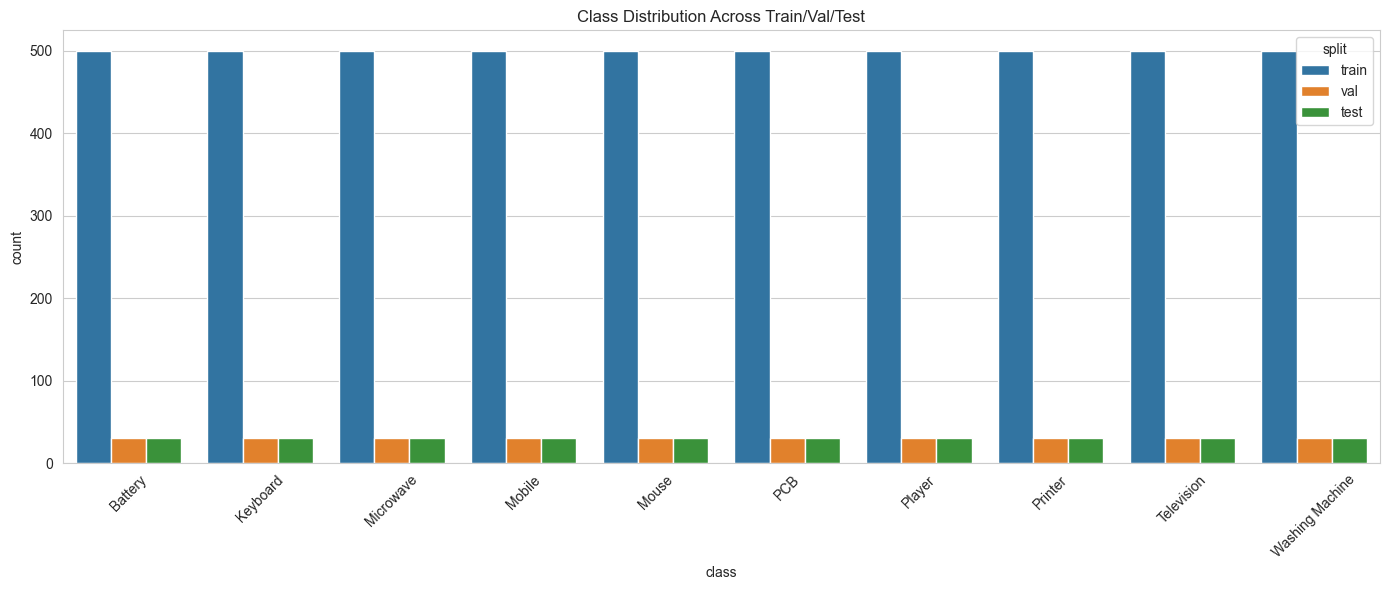

In [74]:
# Step 5: Balance classes via augmentation
for cls in train_stats:
    cls_path = os.path.join(TRAIN_DIR, cls)
    current_count = len(os.listdir(cls_path))
    if current_count < TARGET_COUNT:
        augment_class_images(cls_path, TARGET_COUNT)

# Step 6: Recount stats and re-plot
train_stats_post = count_images_in_classes(TRAIN_DIR)
print("Updated Train stats (after augmentation):", train_stats_post)
show_class_distribution_barplot(train_stats_post, val_stats, test_stats)

In [75]:
def folder_to_dataframe(base_dir, split):
    data = []
    for cls in list_classes(base_dir):
        cls_path = os.path.join(base_dir, cls)
        for img in os.listdir(cls_path):
            if img.lower().endswith(('jpg', 'jpeg', 'png')):
                data.append({
                    'image_path': os.path.join(cls_path, img),
                    'class': cls,
                    'split': split
                })
    return pd.DataFrame(data)

df_train = folder_to_dataframe(TRAIN_DIR, 'train')
df_val = folder_to_dataframe(VAL_DIR, 'val')
df_test = folder_to_dataframe(TEST_DIR, 'test')

# Merge all for overview
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_all.to_csv("ewaste_dataset_flat.csv", index=False)
print("Saved full image dataframe to ewaste_dataset_flat.csv")


Saved full image dataframe to ewaste_dataset_flat.csv


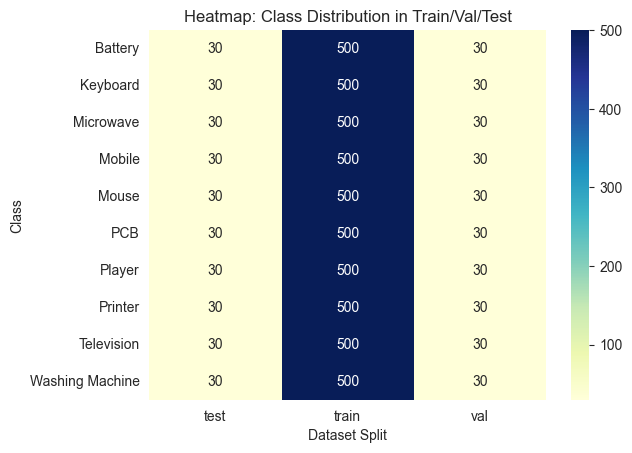

In [76]:
def plot_split_heatmap(df_all):
    pivot = df_all.groupby(['class', 'split']).size().unstack(fill_value=0)
    sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Heatmap: Class Distribution in Train/Val/Test")
    plt.ylabel("Class")
    plt.xlabel("Dataset Split")
    plt.show()

plot_split_heatmap(df_all)


In [77]:
import hashlib

def find_duplicate_images(df):
    hashes = {}
    duplicates = []
    for path in df['image_path']:
        try:
            with open(path, 'rb') as f:
                hash_val = hashlib.md5(f.read()).hexdigest()
                if hash_val in hashes:
                    duplicates.append((hashes[hash_val], path))
                else:
                    hashes[hash_val] = path
        except:
            continue
    return duplicates

dupes = find_duplicate_images(df_all)
print(f"Found {len(dupes)} duplicates.")
for original, duplicate in dupes[:5]:
    print(f"Duplicate: {duplicate} is same as {original}")


Found 31 duplicates.
Duplicate: ewaste-dataset\train\Mobile\Mobile_6.jpg is same as ewaste-dataset\train\Mobile\Mobile_56.jpg
Duplicate: ewaste-dataset\train\Mouse\Mouse_180.jpg is same as ewaste-dataset\train\Mouse\Mouse_153.jpg
Duplicate: ewaste-dataset\train\Mouse\Mouse_185.jpg is same as ewaste-dataset\train\Mouse\Mouse_155.jpg
Duplicate: ewaste-dataset\train\Mouse\Mouse_186.jpg is same as ewaste-dataset\train\Mouse\Mouse_179.jpg
Duplicate: ewaste-dataset\train\Mouse\Mouse_201.jpg is same as ewaste-dataset\train\Mouse\Mouse_171.jpg


In [78]:
def check_class_name_typos(base_path):
    classes = list_classes(base_path)
    print("Detected classes:", classes)
    # Optional: Use fuzzy matching if needed
    return classes

check_class_name_typos(TRAIN_DIR)


Detected classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


['Battery',
 'Keyboard',
 'Microwave',
 'Mobile',
 'Mouse',
 'PCB',
 'Player',
 'Printer',
 'Television',
 'Washing Machine']

In [79]:
def remove_too_small_images(base_path, min_bytes=1000):
    for cls in list_classes(base_path):
        cls_path = os.path.join(base_path, cls)
        for img in os.listdir(cls_path):
            fpath = os.path.join(cls_path, img)
            if os.path.getsize(fpath) < min_bytes:
                print(f"Removed small file: {fpath}")
                os.remove(fpath)

remove_too_small_images(TRAIN_DIR)


In [80]:
def check_image_modes(base_path):
    modes = defaultdict(int)
    for cls in list_classes(base_path):
        cls_path = os.path.join(base_path, cls)
        for img in os.listdir(cls_path):
            try:
                mode = Image.open(os.path.join(cls_path, img)).mode
                modes[mode] += 1
            except:
                continue
    print("Image modes found:", dict(modes))

check_image_modes(TRAIN_DIR)


Image modes found: {'RGB': 5000}


C:\Users\sarve\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sarve\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128208 missing from current font.
  font.set_text(s, 0, flags=flags)


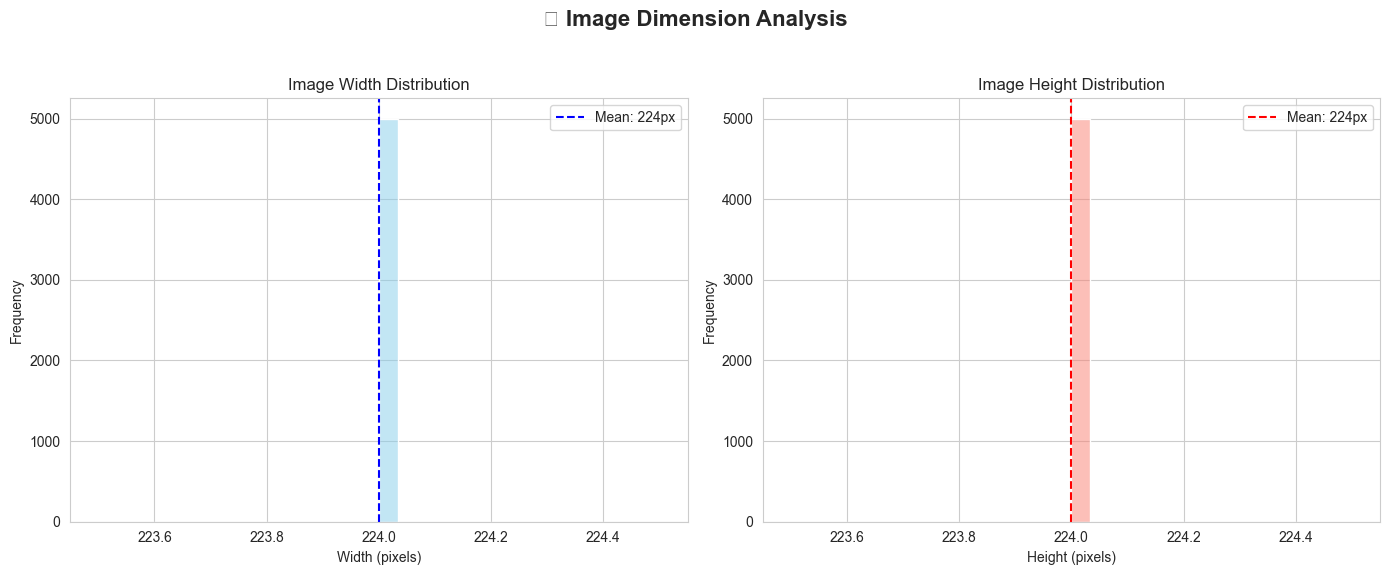


📊 Image Size Summary:
Width:  Min = 224, Max = 224, Mean = 224
Height: Min = 224, Max = 224, Mean = 224


In [81]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

def plot_image_dimension_distribution(base_path, save=False, save_path="image_size_distribution.png"):
    widths, heights = [], []

    for cls in sorted(os.listdir(base_path)):
        cls_path = os.path.join(base_path, cls)
        if not os.path.isdir(cls_path):
            continue
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                continue

    # Create a DataFrame for Seaborn
    df = pd.DataFrame({'Width': widths, 'Height': heights})
    mean_w, mean_h = int(df['Width'].mean()), int(df['Height'].mean())

    # Set up plotting style
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))

    # Plot Width Distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df['Width'], bins=30, kde=True, color='skyblue')
    plt.axvline(mean_w, color='blue', linestyle='--', label=f'Mean: {mean_w}px')
    plt.title("Image Width Distribution")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Frequency")
    plt.legend()

    # Plot Height Distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df['Height'], bins=30, kde=True, color='salmon')
    plt.axvline(mean_h, color='red', linestyle='--', label=f'Mean: {mean_h}px')
    plt.title("Image Height Distribution")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Frequency")
    plt.legend()

    plt.suptitle("📐 Image Dimension Analysis", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        plt.savefig(save_path)
        print(f"✅ Saved plot to {save_path}")

    plt.show()

    # Print summary
    print("\n📊 Image Size Summary:")
    print(f"Width:  Min = {df['Width'].min()}, Max = {df['Width'].max()}, Mean = {mean_w}")
    print(f"Height: Min = {df['Height'].min()}, Max = {df['Height'].max()}, Mean = {mean_h}")

plot_image_dimension_distribution('ewaste-dataset/train')

In [82]:
def dataset_size_in_mb(base_path):
    total = 0
    for root, _, files in os.walk(base_path):
        for file in files:
            total += os.path.getsize(os.path.join(root, file))
    return round(total / (1024 * 1024), 2)

print(f"Train size: {dataset_size_in_mb(TRAIN_DIR)} MB")
print(f"Val size: {dataset_size_in_mb(VAL_DIR)} MB")
print(f"Test size: {dataset_size_in_mb(TEST_DIR)} MB")


Train size: 34.02 MB
Val size: 1.78 MB
Test size: 1.79 MB


In [83]:
import zipfile

def zip_dataset(source_dir, zip_name):
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file), os.path.join(source_dir, '..')))
    print(f"Created zip: {zip_name}")

zip_dataset(DATASET_DIR, 'e-waste-cleaned.zip')


Created zip: e-waste-cleaned.zip


In [84]:
def per_class_resolution_stats(base_path):
    resolution_stats = {}
    for cls in list_classes(base_path):
        widths, heights = [], []
        cls_path = os.path.join(base_path, cls)
        for img in os.listdir(cls_path):
            try:
                im = Image.open(os.path.join(cls_path, img))
                w, h = im.size
                widths.append(w)
                heights.append(h)
            except:
                continue
        if widths and heights:
            resolution_stats[cls] = {
                'min_width': min(widths),
                'max_width': max(widths),
                'min_height': min(heights),
                'max_height': max(heights),
                'avg_w': sum(widths)//len(widths),
                'avg_h': sum(heights)//len(heights)
            }
    return resolution_stats

res_stats = per_class_resolution_stats(TRAIN_DIR)
print("Per-class image resolution summary:")
for cls, stats in res_stats.items():
    print(f"{cls}: {stats}")


Per-class image resolution summary:
Battery: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
Keyboard: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
Microwave: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
Mobile: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
Mouse: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
PCB: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
Player: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
Printer: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_height': 224, 'avg_w': 224, 'avg_h': 224}
Television: {'min_width': 224, 'max_width': 224, 'min_height': 224, 'max_

In [85]:
def rename_files_with_labels(base_path):
    for cls in list_classes(base_path):
        cls_path = os.path.join(base_path, cls)
        for i, img in enumerate(os.listdir(cls_path)):
            ext = img.split('.')[-1]
            new_name = f"{cls}_{i}.{ext}"
            os.rename(os.path.join(cls_path, img), os.path.join(cls_path, new_name))
    print("Renamed all files with class prefix.")


In [86]:
from datetime import datetime

def log_action(msg, logfile='wrangling_log.txt'):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(logfile, 'a') as f:
        f.write(f"[{timestamp}] {msg}\n")
log_action("Removed 38 corrupted images from train/keyboard.")
log_action("Augmented 'washing_machine' to 500 samples.")
log_action("Saved class distribution plot to dist_plot.png.")


In [87]:
def save_flat_csv_split(base_path, split, csv_file):
    rows = []
    for cls in list_classes(base_path):
        for img in os.listdir(os.path.join(base_path, cls)):
            rows.append({
                'filepath': os.path.join(base_path, cls, img),
                'label': cls,
                'split': split
            })
    df = pd.DataFrame(rows)
    df.to_csv(csv_file, index=False)
    print(f"Saved {split} dataset to {csv_file}")

save_flat_csv_split(TRAIN_DIR, 'train', 'train_data.csv')
save_flat_csv_split(VAL_DIR, 'val', 'val_data.csv')
save_flat_csv_split(TEST_DIR, 'test', 'test_data.csv')


Saved train dataset to train_data.csv
Saved val dataset to val_data.csv
Saved test dataset to test_data.csv


In [88]:
import cv2

def remove_blurry_images(base_path, threshold=50.0):
    for cls in list_classes(base_path):
        cls_path = os.path.join(base_path, cls)
        for img in os.listdir(cls_path):
            try:
                img_path = os.path.join(cls_path, img)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    continue
                variance = cv2.Laplacian(image, cv2.CV_64F).var()
                if variance < threshold:
                    print(f"Removed blurry image: {img_path}")
                    os.remove(img_path)
            except:
                continue

# Apply to all splits if needed
remove_blurry_images(TRAIN_DIR)


Removed blurry image: ewaste-dataset\train\Mobile\aug_36086_aug_84243_Mobile_21.jpg
Removed blurry image: ewaste-dataset\train\Television\aug_45074_aug_15526_Television_135.jpg
Removed blurry image: ewaste-dataset\train\Television\aug_89090_aug_62484_Television_180.jpg


In [89]:
def generate_dataset_readme(train_stats, val_stats, test_stats, filename="DATASET_README.txt"):
    total_train = sum(train_stats.values())
    total_val = sum(val_stats.values())
    total_test = sum(test_stats.values())

    with open(filename, 'w', encoding='utf-8') as f:
        f.write("📦 E-Waste Image Dataset\n")
        f.write("========================\n\n")
        f.write(f"Total Train Images: {total_train}\n")
        f.write(f"Total Val Images: {total_val}\n")
        f.write(f"Total Test Images: {total_test}\n\n")
        f.write("Classes:\n")
        for cls in train_stats:
            f.write(f"- {cls} (train: {train_stats[cls]}, val: {val_stats.get(cls,0)}, test: {test_stats.get(cls,0)})\n")
    print(f"Saved dataset description to {filename}")
generate_dataset_readme(train_stats, val_stats, test_stats, filename="DATASET_README.txt")


Saved dataset description to DATASET_README.txt


In [90]:
def cache_resized_images(base_path, output_dir, size=(224,224)):
    os.makedirs(output_dir, exist_ok=True)
    for cls in list_classes(base_path):
        src_cls = os.path.join(base_path, cls)
        dst_cls = os.path.join(output_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for img in os.listdir(src_cls):
            try:
                im = Image.open(os.path.join(src_cls, img)).resize(size)
                im.save(os.path.join(dst_cls, img))
            except:
                continue
    print(f"Resized and cached images in {output_dir}")


In [91]:
cache_resized_images('ewaste-dataset/train', 'ewaste-dataset/train_resized')
cache_resized_images('ewaste-dataset/val', 'ewaste-dataset/val_resized')
cache_resized_images('ewaste-dataset/test', 'ewaste-dataset/test_resized')

Resized and cached images in ewaste-dataset/train_resized
Resized and cached images in ewaste-dataset/val_resized
Resized and cached images in ewaste-dataset/test_resized
